# [Problem 1] Code review

- ResNet est utilisé au lieu de u-net
- Ont utilise les couches qui ont été apprises en utilisant image-net.

In [1]:
import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm
from tqdm import tqdm_notebook
from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.losses import binary_crossentropy
from keras.applications.vgg19 import VGG19, preprocess_input
import tensorflow.compat.v1 as tf
import warnings
# from keras import backend as K
import tensorflow.keras.backend as K  # Import the correct backend module

warnings.filterwarnings('ignore')

%matplotlib inline


plt.rcParams['figure.figsize'] = (12, 9)

In [2]:
train = pd.read_csv("D:\competition_data\\train.csv")
test = pd.read_csv("D:\competition_data\sample_submission.csv")
depth = pd.read_csv("D:\competition_data\depths.csv")

train_src = '../train_data/'

print('train:\n{}'.format(train.head()))
print('\ntest:\n{}'.format(test.head()))


train = train.merge(depth, how='left', on='id')
test = test.merge(depth, how='left', on='id')

len(train)

train:
           id                                           rle_mask
0  2c45b152f1  99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...
1  3cb59a4fdc                                             1 5656
2  e185ab5dc1  4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...
3  c78c89577c                                              101 1
4  6306dd3a8e  1 30 102 29 203 29 304 28 405 27 506 27 607 26...

test:
           id rle_mask
0  3e06571ef3      1 1
1  a51b08d882      1 1
2  c32590b06f      1 1
3  15f7a047c7      1 1
4  e8827bc832      1 1


4000

In [3]:
X_train = np.asarray( [cv2.imread(f'D:\competition_data\\train\images\{x}.png', 0) for x in train.id.tolist()], dtype=np.uint8) / 255.
y_train = np.asarray( [cv2.imread(f'D:\competition_data\\train\masks\{x}.png', 0) for x in train.id.tolist()], dtype=np.uint8) / 255.

print(X_train.shape, y_train.shape)

(4000, 101, 101) (4000, 101, 101)


In [4]:
def compute_coverage(df, masks):
  df = df.copy()
  
  def cov_to_class(val):
    for i in range(0, 11):
      if val * 10 <= i:
        return i

  df['coverage'] = np.mean(masks, axis=(1, 2))
  df['coverage_class'] = df.coverage.map(cov_to_class)

  return df

def create_depth_abs_channels(image_tensor):
  image_tensor = image_tensor.astype(np.float32)
  h, w, c = image_tensor.shape
  for row, const in enumerate(np.linspace(0, 1, h)):
    image_tensor[row, :, 1] = const
  image_tensor[:, :, 2] = (image_tensor[:, :, 0] * image_tensor[:, :, 1])

  x_dx = np.diff(image_tensor[:, :, 0], axis=0)
  x_dy = np.diff(image_tensor[:, :, 0], axis=1)
  x_dx = cv2.copyMakeBorder(x_dx, 1, 0, 0, 0, cv2.BORDER_CONSTANT, 0)
  x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)
  image_tensor[:, :, 1] = np.abs(x_dx + x_dy)
  return image_tensor

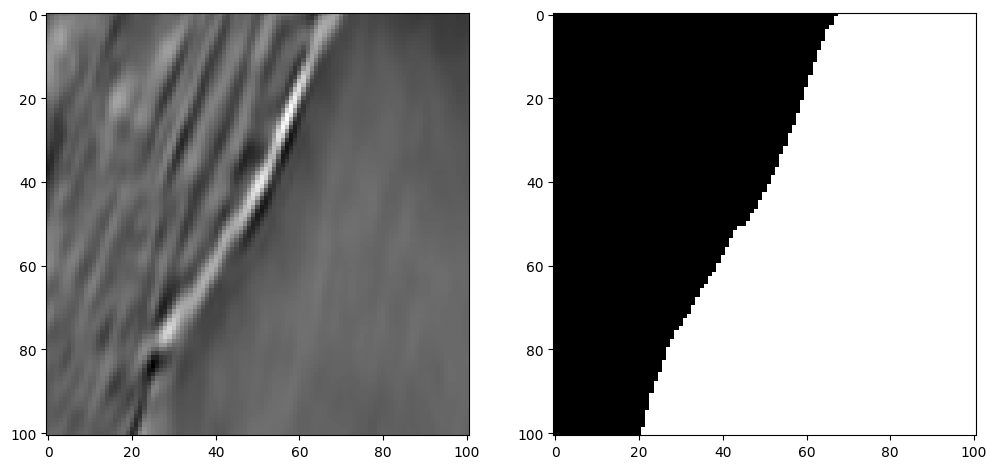

In [5]:
random_index = np.random.randint(0, X_train.shape[0])

fig, ax = plt.subplots(1, 2)

ax[0].imshow(X_train[random_index], cmap='gray')
ax[1].imshow(y_train[random_index], cmap='gray')

In [6]:
train = compute_coverage(train, y_train)

In [7]:
kfold = StratifiedKFold(n_splits=5)

X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))

for train_index, valid_index in kfold.split(train.id.values, train.coverage_class.values):
  X_tr, X_val = X_resized[train_index], X_resized[valid_index]
  y_tr, y_val = y_resized[train_index], y_resized[valid_index]
  break

y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

del X_train_ch, y_resized
del X_resized

gc.collect()

(3200, 224, 224, 3) (3200, 224, 224, 1)
(800, 224, 224, 3) (800, 224, 224, 1)


30

In [8]:
import numpy as np
import cv2
import gc
from sklearn.model_selection import StratifiedKFold

# Assuming X_train and y_train are defined and in correct shape
kfold = StratifiedKFold(n_splits=5)

# Repeat and create depth channels
X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

# Resize input images and masks
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))

# K-Fold cross-validation
for train_index, valid_index in kfold.split(train.id.values, train.coverage_class.values):
	X_tr, X_val = X_resized[train_index], X_resized[valid_index]
	y_tr, y_val = y_resized[train_index], y_resized[valid_index]
	break  

# Expand dimensions for the target masks
y_tr = np.expand_dims(y_tr, axis=-1)  
y_val = np.expand_dims(y_val, axis=-1)  

# Print shapes for verification
print("Training Data Shapes:")
print(X_tr.shape, y_tr.shape)  
print("Validation Data Shapes:")
print(X_val.shape, y_val.shape)  

# Clean up memory
del X_train_ch, y_resized
del X_resized
gc.collect()


Training Data Shapes:
(3200, 224, 224, 3) (3200, 224, 224, 1)
Validation Data Shapes:
(800, 224, 224, 3) (800, 224, 224, 1)


0

In [9]:
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred = K.cast(y_pred, 'float32')
  y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
  intersection = y_true_f * y_pred_f
  score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
  return score

def dice_loss(y_true, y_pred):
  smooth = 1.
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = y_true_f * y_pred_f
  score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  return 1. - score

def bce_dice_loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def lovasz_grad(gt_sorted):
  gts = tf.reduce_sum(gt_sorted)
  intersection = gts - tf.cumsum(gt_sorted)
  union = gts + tf.cumsum(1. - gt_sorted)
  jaccard = 1. - intersection / union
  jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
  return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
  if per_image:
    def treat_image(log_lab):
      log, lab = log_lab
      log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
      log, lab = flatten_binary_scores(log, lab, ignore)
      return lovasz_hinge_flat(log, lab)
    losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
    loss = tf.reduce_mean(losses)
  else:
    loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
  return loss

def lovasz_hinge_flat(logits, labels):
  def compute_loss():
    labelsf = tf.cast(labels, logits.dtype)
    signs = 2. * labelsf - 1.
    errors = 1. - logits * tf.stop_gradient(signs)
    errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
    gt_sorted = tf.gather(labelsf, perm)
    grad = lovasz_grad(gt_sorted)
    loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
    return loss
  
  loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                 lambda: tf.reduce_sum(logits) * 0.,
                 compute_loss,
                 strict=True,
                 name="loss")
  return loss

def flatten_binary_scores(scores, labels, ignore=None):
  scores = tf.reshape(scores, (-1,))
  labels = tf.reshape(labels, (-1,))
  if ignore is None:
    return scores, labels
  valid = tf.not_equal(labels, ignore)
  vscores = tf.boolean_mask(scores, valid, name='valid_scores')
  vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
  return vscores, vlabels

def lovasz_loss(y_true, y_pred):
  y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
  logits = y_pred
  loss = lovasz_hinge(logits, y_true, per_image=True, ignore=None)
  return loss

def get_iou_vector(A, B):
  batch_size = A.shape[0]
  metric = 0.0
  for batch in range(batch_size):
    t, p = A[batch], B[batch]
    true = np.sum(t)
    pred = np.sum(p)
    if true == 0:
      metric += (pred == 0)
      continue
    intersection = np.sum(t * p)
    union = true + pred - intersection
    iou = intersection / union
    iou = np.floor(max(0, (iou - 0.45)*20)) / 10
    metric += iou
  metric /= batch_size
  return metric

def my_iou_metric(label, pred):
  return tf.py_function(get_iou_vector, [label, pred > 0.5], tf.float64)

def my_iou_metric_2(label, pred):
  return tf.py_function(get_iou_vector, [label, pred > 0], tf.float64)

In [10]:
input_size = (224, 224, 3)
base_model = ResNet50(input_shape=input_size, include_top=False)
base_model.summary() 

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

  base_model = ResNet50(input_shape=input_size, 
                        include_top=False,
                        weights=weights)
    
  encoder1 = base_model.get_layer('conv1_conv').output
  encoder2 = base_model.get_layer('conv2_block3_3_conv').output
  encoder3 = base_model.get_layer('conv3_block4_3_conv').output
  encoder4 = base_model.get_layer('conv4_block5_3_conv').output
  encoder5 = base_model.get_layer('conv5_block2_3_conv').output

  center = decoder_block(encoder5, 'center', num_filters=512)
  concat5 = concatenate([center, encoder5], axis=-1)

  decoder4 = decoder_block(concat5, 'decoder4', num_filters=256)
  concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

  decoder3 = decoder_block(concat4, 'decoder3', num_filters=128)
  concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

  decoder2 = decoder_block(concat3, 'decoder2', num_filters=64)
  concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

  decoder1 = decoder_block(concat2, 'decoder1', num_filters=64)
  concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

  output = UpSampling2D()(concat1)
  output = decoder_block(output, 'decoder_output', num_filters=32)
  output = Conv2D(1, (1, 1), activation=None, name='prediction')(output)
  
  if not use_lovash:
    output = Activation('sigmoid')(output)
        
  model = Model(base_model.input, output)
  model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

  return model


In [12]:
def decoder_block_simple(
    layer_name, block_name,
    num_filters=32,
    conv_dim=(3, 3)):

  x_dec = Conv2D(num_filters, conv_dim,
                 padding='same',
                 name='{}_conv'.format(block_name))(layer_name)
  x_dec = BatchNormalization(name='{}_bn'.format(block_name))(x_dec)
  x_dec = PReLU(name='{}_activation'.format(block_name))(x_dec)

  return x_dec

def decoder_block_bottleneck(
    layer_name, block_name,
    num_filters=32,
    conv_dim=(3, 3),
    dropout_frac=0.2):

  x_dec = Conv2D(num_filters, conv_dim,
                 padding='same',
                 name='{}_conv1'.format(block_name))(layer_name)
  x_dec = BatchNormalization(name='{}_bn1'.format(block_name))(x_dec)
  x_dec = PReLU(name='{}_activation1'.format(block_name))(x_dec)
  x_dec = Dropout(dropout_frac)(x_dec)

  x_dec2 = Conv2D(num_filters // 2, conv_dim,
                  padding='same',
                  name='{}_conv2'.format(block_name))(x_dec)
  x_dec2 = BatchNormalization(name='{}_bn2'.format(block_name))(x_dec2)
  x_dec2 = PReLU(name='{}_activation2'.format(block_name))(x_dec2)
  x_dec2 = Dropout(dropout_frac)(x_dec2)

  x_dec2 = Conv2D(num_filters, conv_dim,
                  padding='same',
                  name='{}_conv3'.format(block_name))(x_dec2)
  x_dec2 = BatchNormalization(name='{}_bn3'.format(block_name))(x_dec2)
  x_dec2 = PReLU(name='{}_activation3'.format(block_name))(x_dec2)
  x_dec2 = Dropout(dropout_frac)(x_dec2)

  x_dec2 = Add()([x_dec, x_dec2])

  return x_dec2

In [13]:
#try the model
input_size = (224, 224, 3)
tf.keras.backend.clear_session()
model = unet_resnet(input_size, decoder_block_simple, weights='imagenet')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 38,432,065 (146.61 MB)

 Trainable params: 38,387,073 (146.44 MB)

 Non-trainable params: 44,992 (175.75 KB)

In [14]:
model_depth = unet_resnet(input_size, decoder_block_simple, weights='imagenet', loss_func=bce_dice_loss, metrics_list=[my_iou_metric], use_lovash=False)
print(model_depth.summary())

model_checkpoint = ModelCheckpoint('unet_resnet.weights.h5', monitor='val_my_iou_metric', mode='max', save_best_only=True, save_weights_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 1
batch_size = 16

# history = model_depth.fit(X_tr[:32], y_tr[:32], validation_data=(X_val[:32], y_val[:32]), epochs=epochs, batch_size=batch_size, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 38,432,065 (146.61 MB)

 Trainable params: 38,387,073 (146.44 MB)

 Non-trainable params: 44,992 (175.75 KB)

None


In [15]:
val_preds = model_depth.predict(X_val, batch_size=16)
y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step


In [16]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
  labels = y_true_in
  y_pred = y_pred_in
    
  true_objects = 2
  pred_objects = 2

  intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

  area_true = np.histogram(labels, bins=true_objects)[0]
  area_pred = np.histogram(y_pred, bins=pred_objects)[0]
  area_true = np.expand_dims(area_true, -1)
  area_pred = np.expand_dims(area_pred, 0)

  union = area_true + area_pred - intersection
  intersection = intersection[1:, 1:]
  union = union[1:, 1:]
  union[union == 0] = 1e-9

  iou = intersection / union

  def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1
    false_positives = np.sum(matches, axis=0) == 0
    false_negatives = np.sum(matches, axis=1) == 0
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

  prec = []
  if print_table:
    print("Thresh\tTP\tFP\tFN\tPrec.")
    
  for t in np.arange(0.5, 1.0, 0.05):
    tp, fp, fn = precision_at(t, iou)
    if (tp + fp + fn) > 0:
      p = tp / (tp + fp + fn)
    else:
      p = 0
    if print_table:
      print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
    prec.append(p)
    
  if print_table:
    print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    
  return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
  batch_size = y_true_in.shape[0]
  metric = []
  for batch in range(batch_size):
    value = iou_metric(y_true_in[batch], y_pred_in[batch])
    metric.append(value)
    
  return np.mean(metric)

In [17]:
# Threshold range, over which optimization is performed
thresholds = np.arange(0.2, 0.9, 0.02)

ious = np.array( [iou_metric_batch(y_val_true, np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 35/35 [00:42<00:00,  1.23s/it]


In [18]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format( df_iou.iou[best_index], df_iou.threshold[best_index]) )

df_iou.describe()

Best IoU: 0.5221 at threshold: 0.600


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.386914
std,0.204939,0.201054
min,0.200000,0.000250
25%,0.370000,0.287562
50%,0.540000,0.518375
75%,0.710000,0.522125
max,0.880000,0.522125


<Axes: xlabel='threshold'>

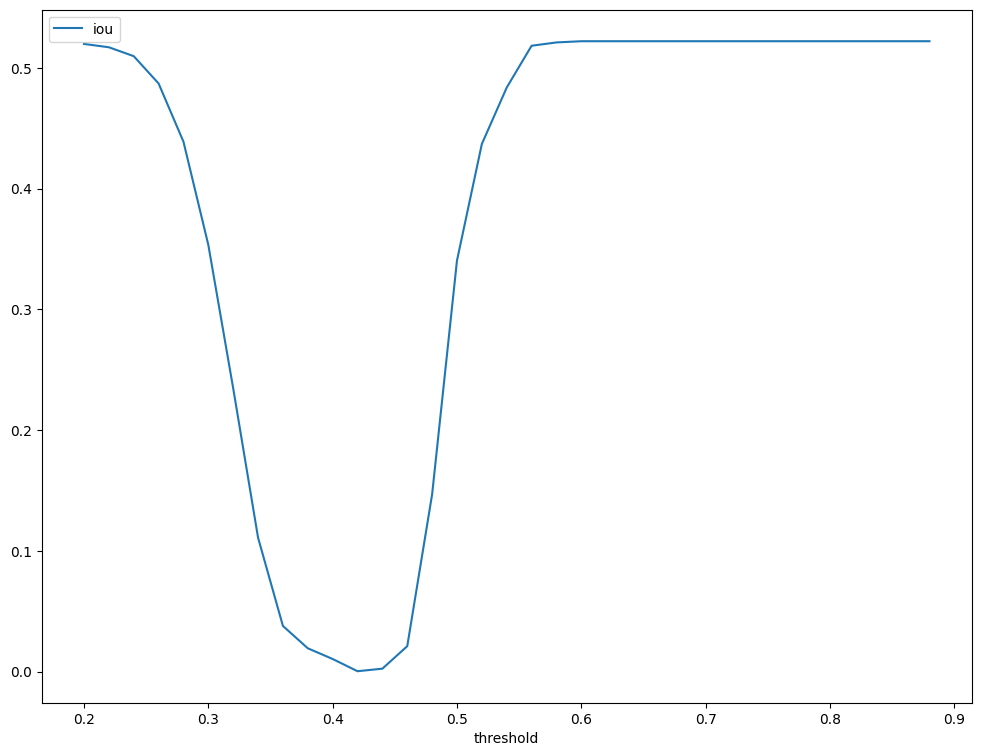

In [19]:
df_iou.plot(x='threshold', y='iou')

# [Problem 2] Code rewriting

In [20]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred = K.cast(y_pred, 'float32')
  y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
  intersection = y_true_f * y_pred_f
  score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
  return score

def dice_loss(y_true, y_pred):
  smooth = 1.
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = y_true_f * y_pred_f
  score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  return 1. - score

def bce_dice_loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def lovasz_grad(gt_sorted):
  gts = tf.reduce_sum(gt_sorted)
  intersection = gts - tf.cumsum(gt_sorted)
  union = gts + tf.cumsum(1. - gt_sorted)
  jaccard = 1. - intersection / union
  jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
  return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
  if per_image:
    def treat_image(log_lab):
      log, lab = log_lab
      log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
      log, lab = flatten_binary_scores(log, lab, ignore)
      return lovasz_hinge_flat(log, lab)
    losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
    loss = tf.reduce_mean(losses)
  else:
    loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
  return loss

def flatten_binary_scores(scores, labels, ignore=None):
  scores = tf.reshape(scores, (-1,))
  labels = tf.reshape(labels, (-1,))
  if ignore is None:
    return scores, labels
  valid = tf.not_equal(labels, ignore)
  vscores = tf.boolean_mask(scores, valid, name='valid_scores')
  vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
  return vscores, vlabels

def lovasz_loss(y_true, y_pred):
  y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
  logits = y_pred
  loss = lovasz_hinge(logits, y_true, per_image=True, ignore=None)
  return loss

def get_iou_vector(A, B):
  batch_size = A.shape[0]
  metric = 0.0
  for batch in range(batch_size):
    t, p = A[batch], B[batch]
    true = np.sum(t)
    pred = np.sum(p)
    if true == 0:
      metric += (pred == 0)
      continue
    intersection = np.sum(t * p)
    union = true + pred - intersection
    iou = intersection / union
    iou = np.floor(max(0, (iou - 0.45) * 20)) / 10
    metric += iou
  metric /= batch_size
  return metric

def my_iou_metric(y_true, y_pred):
  y_pred = tf.cast(y_pred > 0.5, tf.float32)
  intersect = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersect
  iou = intersect / (union + 1e-6)
  return iou

def my_iou_metric_2(label, pred):
  return tf.py_function(get_iou_vector, [label, pred > 0], tf.float64)


In [21]:
def unet_VGG(input_size, decoder_block,
             weights='imagenet',
             loss_func='binary_crossentropy',
             metrics_list=[my_iou_metric],
             use_lovash=False):

  base_model = VGG19(input_shape=input_size, 
                     include_top=False,
                     weights=weights)

  encoder1 = base_model.get_layer('block1_conv2').output
  encoder2 = base_model.get_layer('block2_conv2').output
  encoder3 = base_model.get_layer('block3_conv4').output
  encoder4 = base_model.get_layer('block4_conv4').output
  encoder5 = base_model.get_layer('block5_conv4').output

  center = decoder_block(encoder5, 'center', num_filters=512)
  concat5 = concatenate([center, encoder5], axis=-1)

  decoder4 = decoder_block(concat5, 'decoder4', num_filters=256)
  concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

  decoder3 = decoder_block(concat4, 'decoder3', num_filters=128)
  concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

  decoder2 = decoder_block(concat3, 'decoder2', num_filters=64)
  concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

  decoder1 = decoder_block(concat2, 'decoder1', num_filters=64)
  concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

  output = decoder_block(concat1, 'decoder_output', num_filters=32)
  output = Conv2D(1, (1, 1), activation=None, name='prediction')(output)
  
  if not use_lovash:
    output = Activation('sigmoid')(output)
        
  model = Model(base_model.input, output)
  model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

  return model


In [25]:
tf.keras.backend.clear_session()
model_depth = unet_resnet(input_size, decoder_block_simple, weights='imagenet', use_lovash=False)

model_checkpoint = ModelCheckpoint('unet_resnet.weights.h5', monitor='val_my_iou_metric', mode='max', save_best_only=True, save_weights_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 1
batch_size = 16

# history = model_depth.fit(X_tr, y_tr, validation_data=(X_val[:32], y_val[:32]), epochs=epochs, batch_size=batch_size, verbose=1)


# [Problem 3] Learning / estimation

In [24]:
tf.keras.backend.clear_session()

model_depth = unet_VGG(input_size, decoder_block_bottleneck, weights='imagenet', loss_func=bce_dice_loss, metrics_list=[my_iou_metric], use_lovash=False)
print(model_depth.summary())

model_checkpoint = ModelCheckpoint('unet_VGG.weights.h5', monitor='val_my_iou_metric', mode='max', save_best_only=True, save_weights_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 1
batch_size = 16

history = model_depth.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[model_checkpoint, reduce_lr], verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 56, 56,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 28, 28,    │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv4[0][

 Total params: 36,339,185 (138.62 MB)

 Trainable params: 36,333,905 (138.60 MB)

 Non-trainable params: 5,280 (20.62 KB)

None
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - loss: 1.0215 - my_iou_metric: 0.4039 
Epoch 1: val_my_iou_metric improved from -inf to 0.41747, saving model to unet_VGG.weights.h5
200/200 ━━━━━━━━━━━━━━━━━━━━ 4768s 24s/step - loss: 1.0210 - my_iou_metric: 0.4042 - val_loss: 0.9887 - val_my_iou_metric: 0.4175 - learning_rate: 0.0010
